In [8]:
import scipy.io
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import random
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Define the file paths for the image and ground truth data
image_path = r'C:\Users\86158\Desktop\DTS201\DTS201TC CW DATASET\PaviaU.mat'
gt_path = r'C:\Users\86158\Desktop\DTS201\DTS201TC CW DATASET\PaviaU_gt.mat'

# Load the image data
image = scipy.io.loadmat(image_path)
image = image['paviaU']  # Read the image data

# Load the ground truth data (assuming the ground truth is a single-channel grayscale image)
ground_truth = scipy.io.loadmat(gt_path)
ground_truth = ground_truth['paviaU_gt']  # Read the ground truth data

In [2]:
# Flatten the 103 feature dimensions of the image into a 1D vector
image_data = image.reshape(-1, 103)

# Flatten the ground truth data into a 1D vector
gt_data = ground_truth.reshape(-1)

# Get the indices of pixels with non-zero labels
non_zero_indices = np.where(gt_data != 0)
image_data_non_zero = image_data[non_zero_indices]
gt_data_non_zero = gt_data[non_zero_indices]

# Use a random forest classifier to obtain feature importance
best_n_estimators = 100
best_num_features = 0
num_features_list = []
best_select_features = None

for n in range(100, 201, 50):
    rf = RandomForestClassifier(n_estimators=n)
    rf.fit(image_data_non_zero, gt_data_non_zero)
    
    # Get feature importance
    feature_importance = rf.feature_importances_

    # Set a threshold for feature selection
    threshold = np.median(feature_importance)
    
    # Select features based on the threshold
    selected_features = np.where(feature_importance > threshold)[0]

    num_features_list.append(len(selected_features))

    # Check if n_estimators yields more selected features
    if len(selected_features) > best_num_features:
        best_num_features = len(selected_features)
        best_n_estimators = n
        best_select_features = selected_features

print(f"Best n_estimators is {best_n_estimators}, selected {best_num_features} features")

# Filter the data to include only the selected features
image_data_non_zero = image_data_non_zero[:, best_select_features]
print('Shape of data after filtering: ', image_data_non_zero.shape)

Best n_estimators is 100, selected 51 features
Shape of data after filtering:  (42776, 51)


In [3]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(image_data_non_zero, gt_data_non_zero, test_size=0.2, random_state=100, stratify=gt_data_non_zero)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [4]:
# Create a cuML SVM classifier with an RBF kernel and specific hyperparameters (you can choose different kernels and parameters)
svm_classifier = SVC(kernel='rbf', C=10, gamma=0.1)

# Train the SVM model on a GPU (cuML provides GPU acceleration for SVM training)
svm_classifier.fit(X_train, y_train)

# Make predictions on the test data using the trained SVM model on the GPU
y_pred = svm_classifier.predict(X_test)

# Calculate the classification accuracy to evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9527816736792893


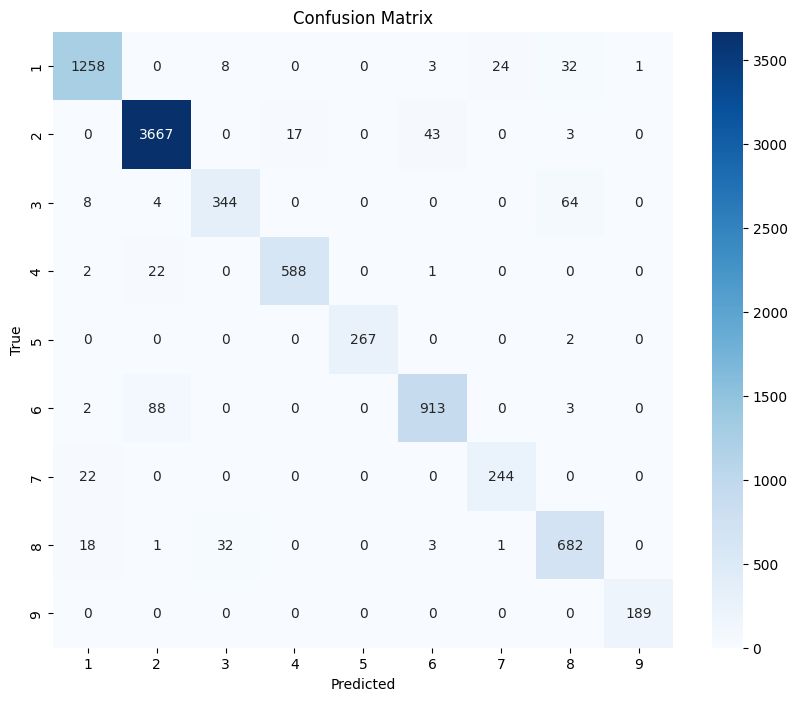

Classification Report:
              precision    recall  f1-score   support

           2       0.96      0.95      0.95      1326
           3       0.97      0.98      0.98      3730
           4       0.90      0.82      0.86       420
           5       0.97      0.96      0.97       613
           6       1.00      0.99      1.00       269
           7       0.95      0.91      0.93      1006
           8       0.91      0.92      0.91       266
           9       0.87      0.93      0.90       737
          10       0.99      1.00      1.00       189

    accuracy                           0.95      8556
   macro avg       0.95      0.94      0.94      8556
weighted avg       0.95      0.95      0.95      8556



In [5]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

y_test = y_test + 1
y_pred = y_pred + 1

# Generate a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Use Seaborn to plot a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[1,2,3,4,5,6,7,8,9], yticklabels=[1,2,3,4,5,6,7,8,9])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Generate and print a classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

In [9]:
#SVM LDA version

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(image_data_non_zero, gt_data_non_zero, test_size=0.2, random_state=100, stratify=gt_data_non_zero)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Calculate the maximum possible LDA dimensions
max_n_components = len(np.unique(y_train)) - 1

# Define a range of LDA dimensions
LDA_dimensions = range(1, max_n_components + 1)
best_accuracy = 0
best_LDA_dimension = 1
best_svm_classifier = None

# Iterate over different LDA dimensions
for n in LDA_dimensions:
    lda = LinearDiscriminantAnalysis(n_components=n)
    X_train_lda = lda.fit_transform(X_train, y_train)
    X_test_lda = lda.transform(X_test)

    # Create an SVM classifier
    svm_classifier = SVC(kernel='rbf', C=10, gamma=0.1)  # You can choose different SVM kernel and parameters

    # Train the SVM classifier on the LDA-reduced data
    svm_classifier.fit(X_train_lda, y_train)

    # Make predictions on the LDA-reduced data
    y_pred = svm_classifier.predict(X_test_lda)

    # Calculate the classification accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Find the best LDA dimension and the corresponding SVM classifier
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_LDA_dimension = n
        best_svm_classifier = svm_classifier

# Output the best LDA dimension and the performance of the best SVM classifier
print('The best LDA dimension is', best_LDA_dimension)
print(f'The best accuracy is {best_accuracy:.2%}')

The best LDA dimension is 7
The best accuracy is 92.98%


In [10]:
#SVM PCA version

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(image_data_non_zero, gt_data_non_zero, test_size=0.2, random_state=100, stratify=gt_data_non_zero)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define a range of PCA components
PCA_components = range(1, min(X_train.shape[1], len(np.unique(y_train))) + 1)
best_accuracy = 0
best_PCA_components = 1
best_svm_classifier = None

# Iterate over different numbers of PCA components
for n in PCA_components:
    pca = PCA(n_components=n)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Create an SVM classifier
    svm_classifier = SVC(kernel='rbf', C=10, gamma=0.1)

    # Train the SVM classifier on the PCA-reduced data
    svm_classifier.fit(X_train_pca, y_train)

    # Make predictions on the PCA-reduced data
    y_pred = svm_classifier.predict(X_test_pca)

    # Calculate the classification accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Find the best number of PCA components and the corresponding SVM classifier
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_PCA_components = n
        best_svm_classifier = svm_classifier

# Output the best number of PCA components and the performance of the best SVM classifier
print('The best PCA components number is', best_PCA_components)
print(f'The best accuracy is {best_accuracy:.2%}')

The best PCA components number is 9
The best accuracy is 94.46%
